In [ ]:
!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/pytorch_weights.tar.gz 
!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/vocab.txt 
!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/config.json 
!tar -xzvf pytorch_weights.tar.gz
!mv config.json pytorch/.
!mv vocab.txt pytorch/.

In [16]:
#Modelo BETO
#Libreria transformers (modelo BERT predefinido para la clasificación (BertForSequenceClassification))
#Libreria sera BERT + Capa de clasificación por encima
#Debemos tokenizar nuestro dataset (tokens + attention mask + max_length)
import torch
from transformers import BertForSequenceClassification, AdamW, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, SequentialSampler

from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import torch.optim
import numpy as np
import pandas as pd
import time
import datetime
import random
from sklearn.metrics import plot_confusion_matrix
from bs4 import BeautifulSoup
from transformers import BertForMaskedLM, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from textwrap import wrap
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
from collections import Counter


import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras 
from keras import backend as K
from keras.layers import LSTM,Dense,Bidirectional,Input
from keras.models import Model

MAX_LEN = 38

# Select cpu or cuda
run_on = 'cpu'
device = torch.device(run_on)

df = pd.read_csv('/Users/nfanlo/Desktop/Python/DataAnalysis/Datasets TFG/TFG/Task1-train-dev/train/train_es.csv')
df_val_mx = pd.read_csv('/Users/nfanlo/Desktop/Python/DataAnalysis/Datasets TFG/TFG/Task1-train-dev/train/train_mx.csv')
print(df.shape)
df.isnull().sum()
df.sentiment.replace("P" , 2 , inplace = True)
df.sentiment.replace("N" , 0 , inplace = True)
df.sentiment.replace("NEU" , 1, inplace = True)
df['review'] = df['text']
df.drop('text', axis=1, inplace=True)
df['label'] = df['sentiment']
df.drop('sentiment', axis=1, inplace=True)
review = df['review']
label = df['label']

print(df)

(1124, 2)
                                                 review  label
0     comprendo que te molen mis tattoos, pero no te...      1
1     Mi última partida jugada, con Sona support. La...      2
2     Tranquilos que con el.dinero de Camacho seguro...      2
3     @daniacal aún no, pero si estará jugable en el...      2
4     @ragnomuelle Yo a veces hecho de menos mi pelo...      0
...                                                 ...    ...
1119  Penoso lo de hoy, pensando en que hacer en el ...      1
1120  q los GP de La Caixa (y otros) manipulen el Ib...      0
1121  Os creéis que es broma que mi foto soy yo desn...      0
1122                         @XbadetaX que es muy cara       0
1123                 @donarfonzo yo no la veo caliente       1

[1124 rows x 2 columns]


In [17]:
#Environment stopwords
stop = set(stopwords.words('spanish'))
punctuation = list(string.punctuation)
stop.update(punctuation)

#Data cleaning stopwords (ignored)
def strip_html(review):
    soup = BeautifulSoup(review, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(review):
    return re.sub('\[[^]]*\]', '', review)
# Removing URL's
def remove_between_square_brackets(review):
    return re.sub(r'http\S+', '', review)
#Removing the stopwords from text
def remove_stopwords(review):
    final_text = []
    for i in review.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(review):
    review = strip_html(review)
    review = remove_between_square_brackets(review)
    review = remove_stopwords(review)
    return review
#Apply function on review column
df['review']=df['review'].apply(denoise_text)

print(df)

                                                 review  label
0                                 comprendo molen hagas      1
1        última partida sona grandes razones jugar sona      2
2     tranquilos camacho seguro mañana empiezan esca...      2
3                         aún si jugable tgs creo tarde      2
4              veces hecho menos pelo largo mismo cosas      0
...                                                 ...    ...
1119    penoso pensando hacer gracias toda gente stream      1
1120  q gp caixa manipulen ibex bendició gracias pod...      0
1121                      creéis broma foto desnuda luz      0
1122                                               cara      0
1123                                       veo caliente      1

[1124 rows x 2 columns]


/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [18]:
review = df['review']
label = df['label']

df_val_mx.sentiment.replace("P" , 2 , inplace = True)
df_val_mx.sentiment.replace("N" , 0 , inplace = True)
df_val_mx.sentiment.replace("NEU" , 1, inplace = True)

print(df_val_mx)

                                                  text  sentiment
0    @leomall2018 Según yo era como aviso, pero aho...          1
1    @benshorts a juzgar por mis comportamientos au...          0
2    #BuenosDias mundo Twittero ya desperté y estoy...          2
3    No pude resolver el rompecabezas en Los rios d...          0
4    o sea ... me urge un Dr. @Rocktor101 (escuchó ...          0
..                                                 ...        ...
984  @ladelbosque29 acude al próximo llamado que ha...          1
985  @Dianybony jajajaja claro que no amor!! te amo...          2
986  Hoy le pedí a Dios una señal realmente obvia, ...          2
987  El reboot de Jumanji puede romper mi corazón x...          0
988  @Djrossana que tengan un lindo martes y que to...          2

[989 rows x 2 columns]


In [19]:
#Environment stopwords
stop = set(stopwords.words('spanish'))
punctuation = list(string.punctuation)
stop.update(punctuation)

#Data cleaning stopwords (ignored)
def strip_html(review):
    soup = BeautifulSoup(review, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(review_mx):
    return re.sub('\[[^]]*\]', '', review_mx)
# Removing URL's
def remove_between_square_brackets(review_mx):
    return re.sub(r'http\S+', '', review_mx)
#Removing the stopwords from text
def remove_stopwords(review_mx):
    final_text = []
    for i in review_mx.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(review_mx):
    review_mx = strip_html(review_mx)
    review_mx = remove_between_square_brackets(review_mx)
    review_mx = remove_stopwords(review_mx)
    return review_mx
#Apply function on review column
df_val_mx['text']=df_val_mx['text'].apply(denoise_text)

print(df_val_mx)

                                                  text  sentiment
0                                  según ahora oficial          1
1    juzgar comportamientos autodestructivos aún qu...          0
2          mundo twittero desperté listo vivir dia mas          2
3    pude resolver rompecabezas rios alicia ahora m...          0
4                       urge programa males digestivos          0
..                                                 ...        ...
984  acude próximo llamado hagamos zapato cerrado c...          1
985                jajajaja claro amo esperando quiero          2
986  hoy pedí dios señal realmente poder tomar impo...          2
987  reboot jumanji puede romper corazón puede ser ...          0
988  lindo martes sueños hagan realidad sé copies m...          2

[989 rows x 2 columns]


/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [20]:
review_mx = df_val_mx['text']
label_mx = df_val_mx['sentiment']
print(review_mx)
print(label_mx)

0                                    según ahora oficial
1      juzgar comportamientos autodestructivos aún qu...
2            mundo twittero desperté listo vivir dia mas
3      pude resolver rompecabezas rios alicia ahora m...
4                         urge programa males digestivos
                             ...                        
984    acude próximo llamado hagamos zapato cerrado c...
985                  jajajaja claro amo esperando quiero
986    hoy pedí dios señal realmente poder tomar impo...
987    reboot jumanji puede romper corazón puede ser ...
988    lindo martes sueños hagan realidad sé copies m...
Name: text, Length: 989, dtype: object
0      1
1      0
2      2
3      0
4      0
      ..
984    1
985    2
986    2
987    0
988    2
Name: sentiment, Length: 989, dtype: int64


In [21]:
# Tokenization

tokenizer = BertTokenizer.from_pretrained('/Users/nfanlo/Python/TFG Decisión multicriterio/Pruebas/BETO',
            do_lower_case=True)

def preprocessing(dataset):
    input_ids = []
    attention_mask = []
    for doc in dataset:
        encoded_doc = tokenizer.encode_plus(doc,
                   add_special_tokens=True, max_length=MAX_LEN,
                   truncation=True ,pad_to_max_length=True,
                   return_token_type_ids = False,
                   return_attention_mask = True,)
        input_ids.append(encoded_doc['input_ids'])
        attention_mask.append(encoded_doc['attention_mask'])
    return (torch.tensor(input_ids),
           torch.tensor(attention_mask))

# Apply preprocessing to dataset
X_train_inputs, X_train_masks = preprocessing(review)
X_val_inputs, X_val_masks = preprocessing(review_mx)

# Report max n° tokens in a sentence
max_len = max([torch.sum(sen) for sen in X_train_masks])

/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [22]:
print(['input_ids'])

['input_ids']


In [33]:
#Data loaders
batch_size = 16

y_train_labels = torch.tensor(label.values)
y_val_labels = torch.tensor(label_mx.values)

def dataloader(x_inputs, x_masks, y_labels):
    data = TensorDataset(x_inputs, x_masks, y_labels)
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size, num_workers=4)
    
    return dataloader

train_dataloader = dataloader(X_train_inputs, X_train_masks, y_train_labels)
val_dataloader = dataloader(X_val_inputs, X_val_masks, y_val_labels)

In [34]:
#Cargamos el modelo + optimizador + definimos EPOCHS + Scheduler
#Modelo
model = BertForSequenceClassification.from_pretrained('/Users/nfanlo/Python/TFG Decisión multicriterio/Pruebas/BETO', num_labels=3,
 output_attentions=False, output_hidden_states=False)

optimizer = AdamW(model.parameters(), lr = 4e-5, eps = 1e-6)

epochs=5

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps= total_steps)

Some weights of the model checkpoint at /Users/nfanlo/Python/TFG Decisión multicriterio/Pruebas/BETO were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were n

In [35]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [36]:
#Definimos una funcion para formatear el tiempo y otra para calcular la exactitud
#fuction to format time
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

#function to compute accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

-----------------Training--------------------

======= Epoch 1 / 5 =======
batch loss: 1.2199769020080566 | avg loss: 1.2199769020080566
batch loss: 1.1200382709503174 | avg loss: 1.170007586479187
batch loss: 0.9305777549743652 | avg loss: 1.0901976426442463
batch loss: 0.9932152628898621 | avg loss: 1.0659520477056503
batch loss: 0.9797075390815735 | avg loss: 1.048703145980835
batch loss: 1.0418909788131714 | avg loss: 1.0475677847862244
batch loss: 0.900810718536377 | avg loss: 1.0266024896076746
batch loss: 1.0906181335449219 | avg loss: 1.0346044450998306
batch loss: 0.9689158201217651 | avg loss: 1.0273057089911566
batch loss: 1.196665644645691 | avg loss: 1.0442417025566102
batch loss: 1.0740602016448975 | avg loss: 1.0469524752009998
batch loss: 1.079559564590454 | avg loss: 1.049669732650121
batch loss: 1.106737494468689 | avg loss: 1.0540595604823186
batch loss: 1.2510312795639038 | avg loss: 1.0681289689881461
batch loss: 0.9576455354690552 | avg loss: 1.06076340675354
batc

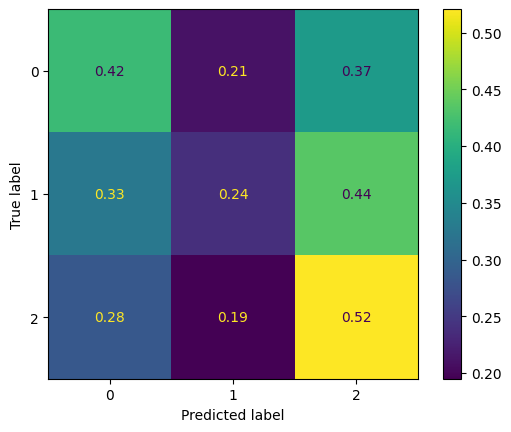

              precision    recall  f1-score   support

           1       0.59      0.42      0.49       504
           2       0.20      0.24      0.22       172
           3       0.38      0.52      0.44       313

    accuracy                           0.42       989
   macro avg       0.39      0.39      0.38       989
weighted avg       0.46      0.42      0.43       989



In [38]:
#Definimos la funcion para entrenar el modelo y entregar los resultados en el set de validación
#Train model
def training(n_epochs, training_dataloader, validation_dataloader):
    print('-----------------Training--------------------')
    for epoch_i in range(0, n_epochs):
        # Perform one full pass over the training set
        print("")
        print('======= Epoch {:} / {:} ======='.format(
             epoch_i + 1, epochs))
        # Mira cuanto tiempo le cuesta entrenar un EPOCH.
        t0 = time.time()
        # Resetea la perdida para este EPOCH.
        total_loss = 0
        # Pone el modelo en modo entrenamiento.
        model.train()
        # Para cada batch en el training data
        for step, batch in enumerate(training_dataloader):
            batch_loss = 0
            # Unpack this training batch from dataloader
            #   [0]: input ids, [1]: attention masks, 
            #   [2]: labels
            b_input_ids,b_input_mask, b_labels = tuple(
                                t.to(device) for t in batch)

            # Limpia el gradiente calculado anteriormente
            model.zero_grad()

            # Genera un paso adelante
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)

            # Saca el loss value fuera del output
            loss = outputs[0]
            batch_loss += loss.item()
            total_loss += loss.item()

            # Genera un paso atras
            loss.backward()

            # Clipea el los gradientes a 1.0.
            torch.nn.utils.clip_grad_norm_(model.parameters(),
                                            1.0)

            # Actualiza los parametros
            # ¿take a step using the computed gradient?
            optimizer.step()
            scheduler.step()

            print('batch loss: {0} | avg loss: {1}'.format(
                  batch_loss, total_loss/(step+1)))
        # Calcula el average loss sobre el training data.
        avg_train_loss = total_loss / len(train_dataloader)


        print("")
        print("  Average training loss: {0:.2f}".
             format(avg_train_loss))
        print("  Training epoch took: {:}".format(
              format_time(time.time() - t0)))

        # ========================================
        #               Validación
        # ========================================
        # Despues de completar un entrenamiento genera un paso de validacion

        print("")
        print("======= Validation =======")

        t0 = time.time()

        # Pone el modelo en modo evaluación
        model.eval()

        # Trackea las variables
        eval_accuracy = 0
        all_logits = []
        all_labels = []
        # Evalua el data para un epoch mas
        for step, batch in enumerate(validation_dataloader):
            # Add batch to device
            # Unpack this training batch from our dataloader.
            #   [0]: input ids, [1]: attention masks,
            #   [2]: labels
            b_input_ids, b_input_mask, b_labels = tuple(
                                t.to(device) for t in batch)


            # El modelo no computa los gradientes
            with torch.no_grad():
                # Paso adelante 
                # Devolvemos los loggits 
                outputs = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask)

            # Los "logits" son el valor de salida
            # Prioriza aplicar la funcion de activación
            logits = outputs[0]

            # Mueve los logits y labels a la CPU
            logits = logits.detach().cpu().numpy()
            b_labels = b_labels.to('cpu').numpy()

            # Guarda los logits y labels del batch
            # Utilizamos esto en la matriz de confusión
            predict_labels = np.argmax(logits, axis=1).flatten()
            all_logits.extend(predict_labels.tolist())
            all_labels.extend(b_labels.tolist())

            # Calcula la precision para este batch
            tmp_eval_accuracy = flat_accuracy(logits, b_labels)
            # Accumula la precisión total
            eval_accuracy += tmp_eval_accuracy

        # Informe de la precisión final de esta ejecución de validación
        print("  Accuracy: {0:.2f}".
            format(eval_accuracy / (step+1)))
        print("  Validation took: {:}".format(
            format_time(time.time() - t0)))
    print("")
    print("Training complete")
    
    #Print la matriz de confussión"
    conf = confusion_matrix(all_labels, all_logits, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=conf)
    disp.plot()
    plt.show()

    target_names = ['1', '2', '3']
    print(classification_report(all_labels, all_logits, target_names=target_names))

    
#Llamamos a la funcion para entrenar el modelo
training(epochs, train_dataloader, val_dataloader)